# Машинное обучение, ФКН ВШЭ

## Практическое задание 12

### Общая информация

Дата выдачи: 9.05.2020

Жёсткий дедлайн: 9.06.2020 23:59MSK

### О задании

Мы будем решать задачу предсказания опасных событий для страховой компании: [Liberty Mutual Group: Property Inspection Prediction](https://www.kaggle.com/c/liberty-mutual-group-property-inspection-prediction). Обучающая выборка состоит из засекреченных признаков целого и строкового типов. Целевой переменной являются счётчики $y \in \mathbb{Z}_+$.

Работа состоит из следующих пунктов:
* Предобработать данные [1 балл]
* Написать свой алгоритм прогнозирования событий [3 балла]
* Настроить линейные методы из библиотеки StatsModels для решения задачи [1 балл]
* Настроить бустинг из библиотеки lightgbm для решения задачи [2 балла]

Задания является дополнительным, то есть само по себе не учитывается в накопленной оценке. Все полученные за задание баллы являются бонусными, то есть их можно прибавить к оценке за любое теоретическое или практическое домашнее задание из курса.


### Оценивание и штрафы
Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 7 баллов.

Сдавать задание после указанного срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.


### Формат сдачи
Для сдачи задания переименуйте получившийся файл *.ipynb в соответствии со следующим форматом: homework-practice-12-Username.ipynb, где Username — ваша фамилия и имя на латинице именно в таком порядке (например, homework-practice-12-IvanovIvan.ipynb). 

Далее отправьте этот файл в AnyTask.

Для удобства проверки самостоятельно посчитайте свою максимальную оценку (исходя из набора решенных задач) и укажите ниже.

** Оценка:** ...

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

from scipy.optimize import minimize
from lightgbm import LGBMModel
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split

pd.set_option('max_rows', 10)
pd.set_option('max_columns', None)
plt.style.use('bmh')

%matplotlib inline

__Задание 1 (1 балл).__ Загрузка и предобработка данных.

In [48]:
data = pd.read_csv('train.csv', index_col='Id')
data.head()

,Hazard,T1_V1,T1_V2,T1_V3,T1_V4,T1_V5,T1_V6,T1_V7,T1_V8,T1_V9,T1_V10,T1_V11,T1_V12,T1_V13,T1_V14,T1_V15,T1_V16,T1_V17,T2_V1,T2_V2,T2_V3,T2_V4,T2_V5,T2_V6,T2_V7,T2_V8,T2_V9,T2_V10,T2_V11,T2_V12,T2_V13,T2_V14,T2_V15
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,1,15,3,2,N,B,N,B,B,D,7,B,B,15,1,A,B,N,36,11,N,10,B,2,37,1,11,6,Y,N,E,2,2
2,4,16,14,5,H,B,N,B,B,C,12,B,B,10,3,A,B,Y,78,10,Y,17,C,2,22,1,18,5,Y,Y,E,2,1
3,1,10,10,5,N,K,N,B,B,E,12,H,B,15,1,A,R,Y,71,21,Y,13,C,6,37,2,14,6,Y,Y,E,6,1
4,1,18,18,5,N,K,N,B,B,E,3,H,B,15,1,A,R,N,71,13,N,15,A,2,25,1,1,6,Y,N,C,2,6
5,1,13,19,5,N,H,N,B,B,E,7,H,B,10,1,A,J,N,75,10,Y,11,B,1,22,1,2,7,N,N,E,1,1


In [49]:
data.shape

(50999, 33)

Выделим категориальные и числовые признаки:

In [50]:
categorical, numerical = list(), list()
for col in data.columns[1:]:
    if isinstance(data.loc[1, col], str):
        categorical.append(col)
    if isinstance(data.loc[1, col], np.int64):
        numerical.append(col)

In [51]:
data[categorical].nunique().values

array([ 8, 10,  2,  4,  4,  6, 12,  4,  8, 18,  2,  2,  6,  2,  2,  5])

In [52]:
data[numerical].nunique().values

array([ 19,  24,   9,   5,   4,   5, 100,  39,  22,   7,   7,   3,  25,
         7,   7,  12])

Нарисуем априорное распределение ответов $p(y)$:

/home/dilara/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/hist.py:62: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  n, bins, patches = ax.hist(y, bins=bins, bottom=bottom, **kwds)


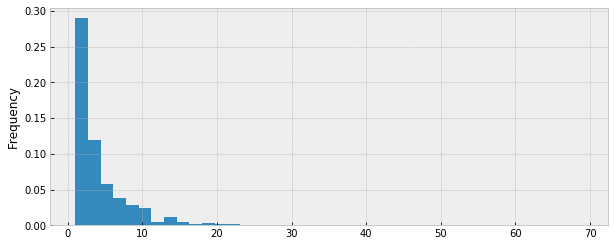

In [53]:
data['Hazard'].plot(kind='hist', figsize=(10, 4), bins=40, normed=True)
plt.show()

В обобщённых линейных моделях, как и в машинном обучении в целом, мы проводим основную работу с апостериорным распределением $p(y|x)$, ведь именно в нём заключается информация о конкретной задаче. Здесь же мы знаем, что количество несчастных случаев во многом подчиняется распределению Пуассона, поэтому будем стараться моделировать именно его.

В выборке могут присутствовать шумовые признаки. Попробуем простейшим способом избавиться от них.

Исследуйте абсолютное значение корреляции:
* Признаков и отклика
* Признаков и логарифма отклика

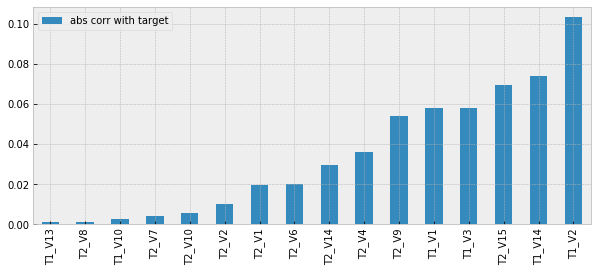

In [54]:
corrs = [data[col].corr(data['Hazard']) for col in numerical]
corrs = pd.DataFrame(np.abs(corrs), numerical, 
    ['abs corr with target']).sort_values('abs corr with target')
corrs.plot(kind='bar', figsize=(10, 4))
plt.show()

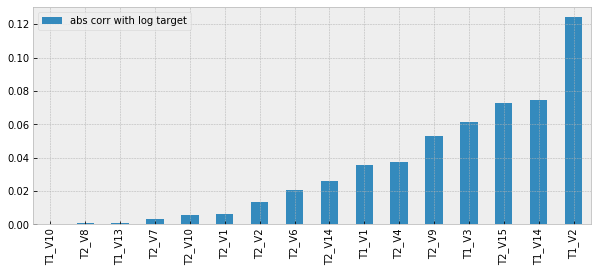

In [55]:
# corr with log(target)
# place your code here

corrs_log = [data[col].corr(np.log(data['Hazard'])) for col in numerical]
corrs_log = pd.DataFrame(np.abs(corrs_log), numerical, 
    ['abs corr with log target']).sort_values('abs corr with log target')
corrs_log.plot(kind='bar', figsize=(10, 4))
plt.show()

Уберите несколько наиболее неинформативных признаков. Лучше сделать это число гиперпараметром и потом настраивать его по функционалу качества. Может быть разумно также исследовать взаимосвязь признаков с логарифмом целевой переменной, поскольку мы предполагаем, что она неотрицательна и имеет распределение Пуассона.

In [56]:
# place your code here
data.drop(columns=['T1_V10', 'T2_V8', 'T1_V13', 'T2_V7'], inplace=True)

Закодируем значения категориальных признаков в числа:

In [57]:
label_encoder = LabelEncoder()
data[categorical] = data[categorical].apply(label_encoder.fit_transform)

Выделим столбец целевой переменной из наших данных. Множество значений случайной величины с распределением Пуассона начинается с нуля $\{0, 1, 2...\}$, поэтому вычтем единицу из целевой переменной. На самом деле, помимо прочего это приводит к существенному росту качества на валидации.

In [58]:
objects = data.loc[:, 'T1_V1':]
labels = data['Hazard'] - 1

Сделаем бинарное кодирование категориальных признаков:

In [59]:
mask = objects.columns.isin(categorical)
onehot_encoder = OneHotEncoder(categorical_features=mask, sparse=False)
objects_encoded = onehot_encoder.fit_transform(objects)

/home/dilara/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)
/home/dilara/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:451: DeprecationWarning: The 'categorical_features' keyword is deprecated in version 0.20 and will be removed in 0.22. You can use the ColumnTransformer instead.
  "use the ColumnTransformer instead.", DeprecationWarning)


Разделим выборку на обучающую и тестовую:

In [63]:
'''train_objects, test_objects, train_labels, test_labels = train_test_split(
    objects_encoded, labels.as_matrix(), random_state=1, test_size=0.2, stratify=labels
)'''
train_objects, test_objects, train_labels, test_labels = train_test_split(
    objects_encoded, labels.as_matrix(), random_state=1, test_size=0.2
)

/home/dilara/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """


__Задание 2 (3 балла).__ Обучение регрессии с распределением Пуассона.

Будем считать, что апостериорное распределение — это распределение Пуассона:

$$p(y|\lambda(x)) = \frac{e^{-\lambda(x)}\lambda(x)^y}{y!}.$$

Реализуйте функции для вычисления функционала качества (через метод максимального правдоподобия) и его градиентов — они были выведены на [семинаре](https://github.com/esokolov/ml-course-hse/blob/master/2017-spring/seminars/sem22-glm.pdf).

Численные алгоритмы должны работать по возможности быстро, поэтому циклов быть не должно, и все операции должны быть векторными. Дальше мы будем использовать эту функцию в качестве аргумента другой функции. Можете попробовать добавить в модель регуляризатор.

In [64]:
def oracle(w, X, y):
    """
    :param w: weights
    :param X: features
    :param y: target
    :yield: loss, grad
    """
    
    # place your code here
    Xw = np.dot(X, w)
    ex = np.exp(Xw)
    loss = np.sum(ex) - np.dot(y, Xw)
    grad = np.dot(X.T, ex - y)
    return loss, grad

Добавьте к признакам столбец единиц, чтобы учесть вектор сдвига. Это важно. Библиотечные алгоритмы уже учитывают это внутри себя, поэтому им на вход нужно подавать исходную выборку.

In [85]:
train_objects_bias = np.c_[train_objects, np.ones(train_objects.shape[0]).reshape(-1, 1)]
test_objects_bias = np.c_[test_objects, np.ones(test_objects.shape[0]).reshape(-1, 1)]

In [86]:
train_objects_bias, test_objects_bias

(array([[ 0.,  0.,  0., ...,  4., 11.,  1.],
        [ 1.,  0.,  0., ...,  2.,  1.,  1.],
        [ 0.,  0.,  0., ...,  3.,  1.,  1.],
        ...,
        [ 0.,  0.,  0., ...,  4.,  1.,  1.],
        [ 0.,  0.,  0., ...,  4.,  2.,  1.],
        [ 0.,  0.,  0., ...,  2.,  1.,  1.]]),
 array([[ 1.,  0.,  0., ...,  2.,  1.,  1.],
        [ 0.,  0.,  0., ...,  1.,  5.,  1.],
        [ 1.,  0.,  0., ...,  1.,  1.,  1.],
        ...,
        [ 0.,  0.,  0., ...,  2., 11.,  1.],
        [ 0.,  0.,  1., ...,  2.,  1.,  1.],
        [ 1.,  0.,  0., ...,  2.,  4.,  1.]]))

Дальше воспользуйтесь функцией _scipy.optimize.minimize_, в ней реализовано множество градиентных методов оптимизации. Рекомендуется взять [L-BFGS-B](http://www.machinelearning.ru/wiki/images/6/65/MOMO17_Seminar6.pdf). Начальное приближение весов $w^{(0)}$ возьмите из стандартного нормального распределения как _np.random.randn_. Возможно, придётся запустить функцию несколько раз, прежде чем начальное приближение окажется удачным, и алгоритм покажет хороший результат. 

Сделайте прогноз для тестовых объектов. В качестве прогноза мы будем брать матожидание распределения $p(y | \lambda(x))$ в данной точке, поэтому не забудьте взять экспоненту от выхода линейной модели, предсказывающей значение натурального параметра. Измерьте качество с помощью коэффициента Джини (чем выше – тем лучше) — именно он является целевой метрикой в соревновании.

In [87]:
def gini(y_true, y_pred):
    # check and get number of samples
    assert y_true.shape == y_pred.shape
    n_samples = y_true.shape[0]
    
    # sort rows on prediction column 
    # (from largest to smallest)
    arr = np.array([y_true, y_pred]).transpose()
    true_order = arr[arr[:,0].argsort()][::-1,0]
    pred_order = arr[arr[:,1].argsort()][::-1,0]
    
    # get Lorenz curves
    L_true = np.cumsum(true_order) / np.sum(true_order)
    L_pred = np.cumsum(pred_order) / np.sum(pred_order)
    L_ones = np.linspace(1/n_samples, 1, n_samples)
    
    # get Gini coefficients (area between curves)
    G_true = np.sum(L_ones - L_true)
    G_pred = np.sum(L_ones - L_pred)
    
    # normalize to true Gini coefficient
    return G_pred/G_true

In [96]:
# place your code here
w0 = np.random.randn(train_objects_bias.shape[1])

poisson_results = minimize(oracle, w0, args=(train_objects_bias, train_labels), method='L-BFGS-B', jac=True) #change parameters
pred_labels = np.exp(test_objects_bias.dot(poisson_results.x)) # w = poisson_results.x
gini(test_labels, pred_labels)

0.33635414656688023

__Задание 3 (1 балл).__ Линейные модели из коробки.

Запустите базовую линейную регрессию *sklearn.linear_model.LinearRegression* для предсказания логарифма целевой переменной и измерьте качество. Сравните полученный результат с работой вашего алгоритма.

In [98]:
# place your code here
linreg = LinearRegression().fit(train_objects, train_labels)
y_pred = linreg.predict(test_objects)
gini(test_labels, y_pred)

0.33312818400877625

Результаты линейной регрессии чуть хуже

Познакомимся теперь с библиотекой [StatsModels](http://www.statsmodels.org/dev/index.html). Она предназначена скорее для описательной статистики, проверки гипотез и построения доверительных интервалов, чем для прогнозирования, — в отличие от scikit-learn, который создан специально для решения задач машинного обучения. В то же время в StatsModels реализован очень сильный алгоритм прогнозирования временных рядов – [SARIMAX](http://www.statsmodels.org/dev/generated/statsmodels.tsa.statespace.sarimax.SARIMAX.html), который при правильной настройке работает очень хорошо и занимает первые места в конкурсах ([Запись трансляции ML тренировки 03.02.18 | TrainMyData Ascott](https://www.youtube.com/watch?v=9MQEEyYDCQc&t=1101s)). 

Мы же попробуем обучить обобщённые линейные модели (модуль [GLM](http://www.statsmodels.org/dev/glm.html)) с различными вероятностными распределениями. Запустите алгоритм _sm.GLM_ на нескольких распределениях family, посмотрите на качество и проинтерпретируйте результаты. Синтаксис StatsModels немного отличается от scikit-learn тем, что здесь объекты и метки задаются в конструкторе модели, метод _fit()_ идёт без аргументов, и после обучения сохраняется новая модель с результатами и методом _predict_.

__Gaussian__

In [99]:
from statsmodels.genmod.families.family import Gaussian, Poisson, NegativeBinomial

In [100]:
#place your code here
gaussian_sm_model = sm.GLM(train_labels, train_objects, family=Gaussian())
gaussian_sm_results = gaussian_sm_model.fit()
pred_labels = gaussian_sm_results.predict(test_objects)
gini(test_labels, pred_labels)

0.33312818400877625

__Poisson__

In [101]:
poisson_sm_model = sm.GLM(train_labels, train_objects, family=Poisson())
poisson_sm_results = poisson_sm_model.fit()
poisson_pred_labels = poisson_sm_results.predict(test_objects)
gini(test_labels, poisson_pred_labels)

0.33644882854732283

__NegativeBinomial (Pascal)__

In [103]:
pascal_sm_model = sm.GLM(train_labels, train_objects, family=NegativeBinomial())
pascal_sm_results = pascal_sm_model.fit()
pascal_pred_labels = pascal_sm_results.predict(test_objects)
gini(test_labels, pascal_pred_labels)

0.33641478128970914

Как видно, качество в последнем случае получилось лучше. -- что-то нет...-- На практике чаще используют именно отрицательное Биномиальное распределение. Оно является обобщением геометрического распределения и даёт некоторую свободу в выборе среднего и дисперсии для $p(y|x)$, тогда как в распределении Пуассона среднее и дисперсия совпадают. Если вам будет интересно, можете прочитать подробнее на вики [NegativeBinomial](https://en.m.wikipedia.org/wiki/Negative_binomial_distribution).

__Задание 4. (2 балла)__ Прогнозирование с помощью бустинга.

Что бы мы ни делали, бустинг по-прежнему остаётся лучшим подходом для широкого круга задач — особенно если мы не работаем со структурированными данными вроде последовательностей или картинок. Бустинг хоть и сложный по своей структуре алгоритм, но вероятностные распределения не чужды и ему. Запустите LGBMModel, используя классическую регрессию и регрессию Пуассона. Настройте параметры, чтобы добиться наилучшего качества. В особенности обратите внимание на *objective*, *n_estimators*, *num_leaves* и *colsample_bytree*.

In [111]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer


params_reg = {'n_estimators':[25, 50, 100],
          'num_leaves':[10, 20, 30],
          'colsample_bytree':[0.3, 0.5, 0.8]}

In [112]:
reg = LGBMModel(objective='regression')

gs_reg = GridSearchCV(reg, params_reg, cv=3, scoring=make_scorer(gini))
gs_reg.fit(train_objects, train_labels)

GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=LGBMModel(boosting_type='gbdt', class_weight=None,
                                 colsample_bytree=1.0, importance_type='split',
                                 learning_rate=0.1, max_depth=-1,
                                 min_child_samples=20, min_child_weight=0.001,
                                 min_split_gain=0.0, n_estimators=100,
                                 n_jobs=-1, num_leaves=31,
                                 objective='regression', random_state=None,
                                 reg_alpha=0.0, reg_lambda=0.0, silent=True,
                                 subsample=1.0, subsample_for_bin=200000,
                                 subsample_freq=0),
             iid='warn', n_jobs=None,
             param_grid={'colsample_bytree': [0.3, 0.5, 0.8],
                         'n_estimators': [25, 50, 100],
                         'num_leaves': [10, 20, 30]},
             pre_dispatch='2*n

In [113]:
gs_reg.best_estimator_

LGBMModel(boosting_type='gbdt', class_weight=None, colsample_bytree=0.3,
          importance_type='split', learning_rate=0.1, max_depth=-1,
          min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
          n_estimators=100, n_jobs=-1, num_leaves=20, objective='regression',
          random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
          subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [115]:
gini(test_labels, gs_reg.best_estimator_.predict(test_objects))

0.37681348333415426

In [ ]:
# objective='poisson'

In [116]:
params_pois = {'n_estimators':[50, 100, 150],
          'num_leaves':[20, 30, 50],
          'colsample_bytree':[0.3, 0.5, 1.0]}
pois = LGBMModel(objective='poisson')

gs_pois = GridSearchCV(pois, params_pois, cv=3, scoring=make_scorer(gini))
gs_pois.fit(train_objects, train_labels)

GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=LGBMModel(boosting_type='gbdt', class_weight=None,
                                 colsample_bytree=1.0, importance_type='split',
                                 learning_rate=0.1, max_depth=-1,
                                 min_child_samples=20, min_child_weight=0.001,
                                 min_split_gain=0.0, n_estimators=100,
                                 n_jobs=-1, num_leaves=31, objective='poisson',
                                 random_state=None, reg_alpha=0.0,
                                 reg_lambda=0.0, silent=True, subsample=1.0,
                                 subsample_for_bin=200000, subsample_freq=0),
             iid='warn', n_jobs=None,
             param_grid={'colsample_bytree': [0.3, 0.5, 1.0],
                         'n_estimators': [50, 100, 150],
                         'num_leaves': [20, 30, 50]},
             pre_dispatch='2*n_jobs', refit=True, return_train_sc

In [117]:
gs_pois.best_estimator_

LGBMModel(boosting_type='gbdt', class_weight=None, colsample_bytree=0.5,
          importance_type='split', learning_rate=0.1, max_depth=-1,
          min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
          n_estimators=150, n_jobs=-1, num_leaves=30, objective='poisson',
          random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
          subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [118]:
gini(test_labels, gs_pois.best_estimator_.predict(test_objects))

0.3831787802268951